In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import feather

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import stats

import warnings

from matplotlib.ticker import MaxNLocator

from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [22]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [2]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather", 
                            columns=["index",
                                     "segment_duration",
                                     "mean_durations_by_segment_code",
                                     "segment_code",
                                     "mean_durations_by_segment_code_and_hour_and_day",
                                     "diff_segment_and_mean_by_segment_code_and_hour_and_day",
                                     "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day",
                                     "median_durations_by_segment_code_and_hour_and_day",
                                     'segment_name',
                                     'actualArrival',
                                     'arrival_hour',
                                     'arrival_day',
                                     'line_distance','to_centre_dist',
                                     'test','train','date',
                                     'stopCode','publicName'
                                     
                                    ])
se = se.set_index(se.columns[0])

In [3]:
first_day_test = se.loc[se["test"], "date"].min()

days = 75

train_days = 0
count = 0

events = se

# This is a little hack to add in days to account for gaps in the records.
while train_days != days and count != 10:

    train = events.loc[
        events["date"].isin(
            pd.date_range(
                start=(first_day_test - pd.Timedelta(f"{days + 1 + count} days")),
                periods=(days + 1 + count),
            )
        )
    ]

    train_days = len(train.groupby("date").first())
    count += 1



In [4]:
len(train.groupby('date').first())

69

In [5]:
first_day_test

Timestamp('2018-12-03 00:00:00')

In [6]:
def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events

se = filter_rare(se)

Calculating rare segments...
	Calculated


In [7]:
def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

In [8]:
def make_prediction(medians, results):
    return medians * (1 + (results / 100))




In [9]:
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

# Sparsity

In [10]:
sparsity = se.groupby(["segment_name", "arrival_hour", "date"]).count()['segment_code']

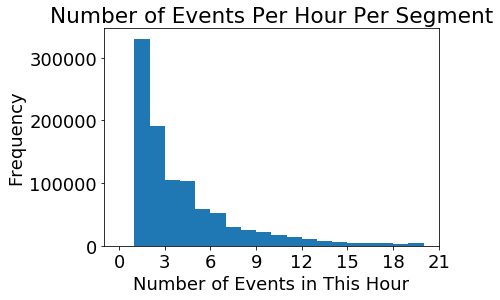

In [23]:
ax = plt.figure().gca()
ax.hist(sparsity, bins=20, range=(0,20));
ax.set_title("Number of Events Per Hour Per Segment")
ax.set_xlabel("Number of Events in This Hour")
ax.set_ylabel("Frequency")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig("Sparsity_events_per_hour.pdf", bbox_inches="tight")

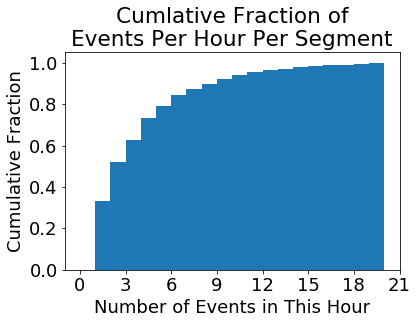

In [29]:
ax = plt.figure().gca()
ax.hist(sparsity, bins=20, range=(0,20), density=True, cumulative=True, linewidth=0,rasterized=True);
ax.set_title("Cumlative Fraction of\nEvents Per Hour Per Segment")
ax.set_xlabel("Number of Events in This Hour")
ax.set_ylabel("Cumulative Fraction")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig("Sparsity_events_per_hour_cum.pdf", bbox_inches="tight")



In [13]:
se_prev_stopCode_route_groups = se.groupby(["stopCode", "publicName"])

se["last_this_bus_gap"] = np.nan
se["next_this_bus_gap"] = np.nan

for _, stop in tqdm(se_prev_stopCode_route_groups):

    stop = stop.sort_values("actualArrival")

    previous_bus = stop.shift(1)
    next_bus = stop.shift(-1)

    se.loc[stop.index, "last_this_bus_gap"] = (
        stop["actualArrival"] - previous_bus["actualArrival"]
    ).astype("<m8[s]")
    se.loc[stop.index, "next_this_bus_gap"] = (
        next_bus["actualArrival"] - stop["actualArrival"]
    ).astype("<m8[s]")

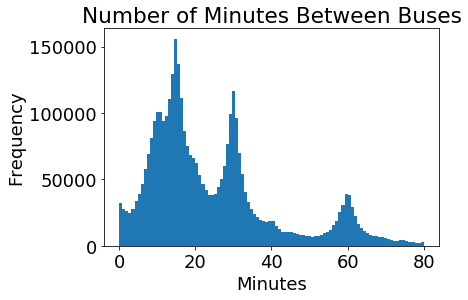

In [27]:
plt.hist(se['last_this_bus_gap']/60, bins=100, range=(0,80), linewidth=0,rasterized=True);
plt.title("Number of Minutes Between Buses")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.savefig("sparsity_mins_between_buses.pdf", bbox_inches="tight")

In [21]:
np.mean(se.loc[se['last_this_bus_gap'] < 60*60*8, 'last_this_bus_gap']/60)

32.622587117186036

In [17]:
np.nanmedian(se['last_this_bus_gap']/60)

20.8

In [259]:
diffs = []

for name, seg in se.groupby("segment_code"):
    
    quantiles = np.quantile(seg['mean_durations_by_segment_code_and_hour_and_day'], [0.25, 0.75])
    
    diffs.append(quantiles[1] - quantiles[0])
    
print(np.mean(diffs))

10.268587099312402


## Looking at Noise now

Starting by making some more averages to compare

In [9]:
se['dry'] = (se['rain'] == 0)
se['weekend'] = (se['arrival_day'] > 4)

In [10]:
segment_code_and_hour_and_daytype_groups = se[se["train"]].groupby(
    ["segment_code", "arrival_hour", "weekend"]
)

median_durations_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["segment_duration"]
    .median()
    .rename("median_durations_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_durations_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [11]:
mean_durations_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["segment_duration"]
    .mean()
    .rename("mean_durations_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    mean_durations_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [12]:
median_prev_dwell_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_prev_dwell_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [13]:
mean_prev_dwell_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["dwell_duration_prev"]
    .mean()
    .rename("mean_prev_dwell_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    mean_prev_dwell_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [19]:
# prev_stopCode_and_public_name_and_hour_and_daytype_groups = se[se["train"]].groupby(
#     ["prev_stopCode", "arrival_hour", "weekend", "publicName"]
# )

# median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype = (
#     prev_stopCode_and_public_name_and_hour_and_daytype_groups["segment_duration"]
#     .median()
#     .rename("median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype")
# )

# se = se.merge(
#     median_durations_by_prev_stop_code_and_public_name_and_hour_and_daytype.to_frame(),
#     "left",
#     left_on=["prev_stopCode", "arrival_hour", "weekend", "publicName"],
#     right_index=True,
# )

In [20]:
# segment_code_and_hour_and_daytype_dry_groups = se[se["train"]].groupby(
#     ["segment_code", "arrival_hour", "weekend", "dry"]
# )

# median_durations_by_segment_code_and_hour_and_daytype_and_dry = (
#     segment_code_and_hour_and_daytype_dry_groups["segment_duration"]
#     .median()
#     .rename("median_durations_by_segment_code_and_hour_and_daytype_and_dry")
# )

# se = se.merge(
#     median_durations_by_segment_code_and_hour_and_daytype_and_dry.to_frame(),
#     "left",
#     left_on=["segment_code", "arrival_hour", "weekend", "dry"],
#     right_index=True,
# )

In [21]:
# median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry = (
#     segment_code_and_hour_and_daytype_dry_groups["dwell_duration_prev"]
#     .median()
#     .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry")
# )

# se = se.merge(
#     median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry.to_frame(),
#     "left",
#     left_on=["segment_code", "arrival_hour", "weekend", "dry"],
#     right_index=True,
# )

In [22]:
segment_code_groups = se[se["train"]].groupby(
    ["segment_code"]
)

median_prev_dwell_by_segment_code = (
    segment_code_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code")
)

se = se.merge(
    median_prev_dwell_by_segment_code.to_frame(),
    "left",
    left_on=["segment_code"],
    right_index=True,
)

In [23]:
mean_prev_dwell_by_segment_code = (
    segment_code_groups["dwell_duration_prev"]
    .mean()
    .rename("mean_prev_dwell_by_segment_code")
)

se = se.merge(
    mean_prev_dwell_by_segment_code.to_frame(),
    "left",
    left_on=["segment_code"],
    right_index=True,
)

In [24]:
mean_durations_by_segment_code = (
    segment_code_groups["segment_duration"]
    .mean()
    .rename("mean_durations_by_segment_code")
)

se = se.merge(
    mean_durations_by_segment_code.to_frame(),
    "left",
    left_on=["segment_code"],
    right_index=True,
)

In [14]:
se['diff_segment_and_median_by_segment_code_and_hour_and_daytype'] = se['segment_duration'] - se['median_durations_by_segment_code_and_hour_and_daytype']
se['diff_segment_and_mean_by_segment_code_and_hour_and_daytype'] = se['segment_duration'] - se['mean_durations_by_segment_code_and_hour_and_daytype']


In [8]:
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = se['segment_duration'] - se["mean_durations_by_segment_code_and_hour_and_day"]

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
        se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
        * 100
        / se["mean_durations_by_segment_code_and_hour_and_day"]
    )

In [30]:
se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'] = se['dwell_duration_prev'] - se['median_prev_dwell_by_segment_code_and_hour_and_daytype']
se['diff_prev_dwell_and_mean_by_segment_code_and_hour_and_daytype'] = se['dwell_duration_prev'] - se['mean_prev_dwell_by_segment_code_and_hour_and_daytype']
se['diff_prev_dwell_and_dwell_predict_rules_mean'] = se['dwell_duration_prev'] - se['dwell_predict_rules_mean']


In [31]:
segment_code_and_hour_and_daytype_groups = None
median_durations_by_segment_code_and_hour_and_daytype = None
median_prev_dwell_by_segment_code_and_hour_and_daytype = None
mean_durations_by_segment_code_and_hour_and_daytype = None
mean_prev_dwell_by_segment_code_and_hour_and_daytype = None

# prev_stopCode_and_public_name_groups = None
# median_durations_by_prev_stop_code_public_name = None
# segment_code_and_hour_and_daytype_dry_groups = None
# median_durations_by_segment_code_and_hour_and_daytype_and_dry = None
# median_prev_dwell_by_segment_code_and_hour_and_daytype_and_dry = None
# segment_code_groups = None
# median_prev_dwell_by_segment_code = None

In [15]:
se.columns

Index(['id', 'date', 'stopCode', 'aimedArrival', 'aimedDeparture',
       'actualArrival', 'actualDeparture', 'vehicle', 'workid', 'patternId',
       ...
       'last_this_bus_gap', 'next_this_bus_gap', 'dwell_predict_rules_median',
       'dwell_predict_rules_mean',
       'median_durations_by_segment_code_and_hour_and_daytype',
       'mean_durations_by_segment_code_and_hour_and_daytype',
       'median_prev_dwell_by_segment_code_and_hour_and_daytype_y',
       'mean_prev_dwell_by_segment_code_and_hour_and_daytype_y',
       'diff_segment_and_median_by_segment_code_and_hour_and_daytype',
       'diff_segment_and_mean_by_segment_code_and_hour_and_daytype'],
      dtype='object', length=118)

## Mapes of various dwell predictions

In [ ]:
print(f"Mean prev dwell: {np.mean(se['dwell_duration_prev'])}")
print(f"Median prev dwell: {np.median(se['dwell_duration_prev'])}")
print(f"Std prev dwell: {np.std(se['dwell_duration_prev'])}")

In [ ]:
plt.hist([se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'], se.loc[se['prev_timingPoint'] == 1, 'dwell_duration_prev']], bins=100, stacked=True, range=(0,100));

In [ ]:
plt.hist(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'], bins=100, range=(-50, 50));


In [10]:
np.mean(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'])


KeyError: 'diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'

In [ ]:
np.std(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'])


In [ ]:
(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['median_dwell_prev_durations_by_stop_code']).std()


## Looking at the bayesian esimates of some means and standard deviations travel times (Mean model)

In [13]:
stats.bayes_mvs(se['diff_segment_and_mean_by_segment_code_and_hour_and_day'], alpha=0.9)

(Mean(statistic=0.18735398410193907, minmax=(0.16001943616363024, 0.2146885320402479)),
 Variance(statistic=1081.6810786441936, minmax=(1080.409695321959, 1082.9524619664282)),
 Std_dev(statistic=32.8889203021959, minmax=(32.869591857988055, 32.90824874640374)))

In [14]:
stats.bayes_mvs(se['mean_durations_by_segment_code_and_hour_and_day'], alpha=0.9)

(Mean(statistic=45.85027328539217, minmax=(45.82444555497585, 45.87610101580849)),
 Variance(statistic=965.712672609974, minmax=(964.5775959129073, 966.8477493070407)),
 Std_dev(statistic=31.075917888454622, minmax=(31.057654925134585, 31.09418085177466)))

In [15]:
stats.bayes_mvs(se['segment_duration'], alpha=0.9)

(Mean(statistic=46.0376272694941, minmax=(46.00007918648389, 46.07517535250432)),
 Variance(statistic=2041.037479589336, minmax=(2038.6384905870893, 2043.4364685915828)),
 Std_dev(statistic=45.17784279477426, minmax=(45.15129229065718, 45.20439329889133)))

In [18]:
(se['mean_durations_by_segment_code_and_hour_and_day'] - se['mean_durations_by_segment_code']).std()


12.927138122842262

In [26]:
(se["segment_duration"] - se['mean_durations_by_segment_code_and_hour_and_day']).std()

32.88616981303493

In [27]:
se["segment_duration"].mean()

46.03960549855144

In [31]:
se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].std()

57.735050514548696

In [32]:
np.mean(np.abs(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day']))

30.46148086848682

## Looking at the bayesian esimates of some means and standard deviations travel times (mean model)

In [ ]:
stats.bayes_mvs(se['diff_segment_and_mean_by_segment_code_and_hour_and_daytype'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se['mean_durations_by_segment_code_and_hour_and_daytype'], alpha=0.9)

In [ ]:
(se['mean_durations_by_segment_code_and_hour_and_daytype'] - se['mean_durations_by_segment_code']).std()

In [ ]:
# Intesrtingly this model gets a little closer to the actual std of the segment durations

np.sqrt(33**2+30**2)

### Same with dwell times (median model)

In [ ]:
stats.bayes_mvs(se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se['dwell_duration_prev'], alpha=0.9)

In [ ]:
(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['median_prev_dwell_by_segment_code']).std()

In [ ]:
(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['median_prev_dwell_by_segment_code']).abs().mean()

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'median_prev_dwell_by_segment_code_and_hour_and_daytype'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'dwell_duration_prev'], alpha=0.9)

### Same with dwell times (mean model)

In [ ]:
stats.bayes_mvs(se['diff_prev_dwell_and_mean_by_segment_code_and_hour_and_daytype'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se['mean_prev_dwell_by_segment_code_and_hour_and_daytype'], alpha=0.9)

In [ ]:
(se['mean_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['mean_prev_dwell_by_segment_code']).std()

In [ ]:
(se['mean_prev_dwell_by_segment_code_and_hour_and_daytype'] - se['mean_prev_dwell_by_segment_code']).abs().mean()

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'diff_prev_dwell_and_mean_by_segment_code_and_hour_and_daytype'], alpha=0.9)


In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'mean_prev_dwell_by_segment_code_and_hour_and_daytype'], alpha=0.9)

### Same with dwell times (rules model)

In [ ]:
stats.bayes_mvs(se['diff_prev_dwell_and_dwell_predict_rules_mean'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se['dwell_predict_rules_mean'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'diff_prev_dwell_and_dwell_predict_rules_mean'], alpha=0.9)

In [ ]:
stats.bayes_mvs(se.loc[se['prev_dwell_type_normal'], 'dwell_predict_rules_mean'], alpha=0.9)

### Find the mean absolute difference and the standard devations of each pair of buses that do the same segment within 5 mins of each other.

In [56]:
se_segment_name_groups = se.groupby("segment_name")

In [195]:
differences = []
duration_differences = []
arrival_hours = []
arrival_days = []
length = []
distance = []
befores = []
afters = []
d_befores = []
d_afters = []
time_delta = []

for name, segment in se_segment_name_groups:
    
    segment = segment.sort_values("actualArrival")
    
    previous_bus = segment.shift(1)
    
    mask = (segment['actualArrival'] - previous_bus['actualArrival']) < pd.Timedelta("10 minute")
    
    befores.extend(previous_bus[mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'])
    afters.extend(segment[mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'])
    
    differences.extend(segment[mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] - previous_bus[mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'])
    
    d_befores.extend(previous_bus[mask]['diff_segment_and_mean_by_segment_code_and_hour_and_day'])
    d_afters.extend(segment[mask]['diff_segment_and_mean_by_segment_code_and_hour_and_day'])

    duration_differences.extend(segment[mask]['diff_segment_and_mean_by_segment_code_and_hour_and_day'] - previous_bus[mask]['diff_segment_and_mean_by_segment_code_and_hour_and_day'])
    
    arrival_hours.extend(segment[mask]['arrival_hour'])
    
    arrival_days.extend(segment[mask]['arrival_day'])
    
    length.extend(segment[mask]['line_distance'])
    
    distance.extend(segment[mask]['to_centre_dist'])
    
    time_delta.extend((segment[mask]['actualArrival'] - previous_bus[mask]['actualArrival']) / np.timedelta64(1, 's'))
    

In [196]:
differences = np.array(differences)
duration_differences = np.array(duration_differences)
arrival_hours = np.array(arrival_hours)
arrival_days = np.array(arrival_days)
length = np.array(length)
distance = np.array(distance)
befores = np.array(befores)
afters = np.array(afters)
d_befores = np.array(d_befores)
d_afters = np.array(d_afters)
time_delta = np.array(time_delta)


In [197]:
len(duration_differences)

1986283

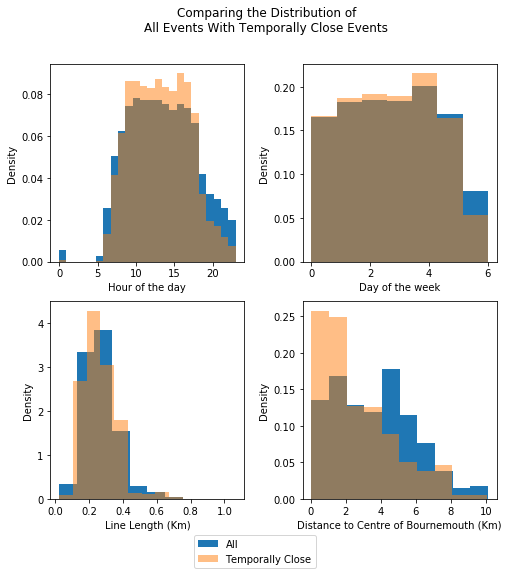

In [191]:
fig = plt.figure(figsize=(8,8))

plt.subplot(2, 2, 1)
plt.hist(se['arrival_hour'], density=True, bins=24, label="All");
plt.hist(arrival_hours, density=True, bins=24, alpha=0.5, label="Temporally Close");
plt.xlabel("Hour of the day")
plt.ylabel("Density")
# plt.title("Comparing the Distribution of All Events With Temporally Close Events")
# plt.legend()

plt.subplot(2, 2, 2)
plt.hist(se['arrival_day'], density=True, bins=7, label="All");
plt.hist(arrival_days, density=True, bins=7, alpha=0.5, label="Temporally Close");
plt.xlabel("Day of the week")
plt.ylabel("Density")
# plt.title("Comparing the Distribution of All Events With Temporally Close Events")
# plt.legend()

plt.subplot(2, 2, 3)
plt.hist(se['line_distance'], density=True, bins=10, label="All");
plt.hist(length, density=True, bins=10, alpha=0.5, label="Temporally Close");
plt.xlabel("Line Length (Km)")
plt.ylabel("Density")
# plt.title("Comparing the Distribution of All Events With Temporally Close Events")
# plt.legend()

plt.subplot(2, 2, 4)
plt.hist(se['to_centre_dist'], density=True, bins=10, label="All");
plt.hist(distance, density=True, bins=10, alpha=0.5, label="Temporally Close");
plt.xlabel("Distance to Centre of Bournemouth (Km)")
plt.ylabel("Density")
# plt.title("Comparing the Distribution of All Events With Temporally Close Events")
# plt.legend()

handles, labels = fig.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')
fig.suptitle("Comparing the Distribution of\nAll Events With Temporally Close Events", fontsize=12)
plt.subplots_adjust(hspace=0.2, wspace=0.3)
plt.savefig("variance_distributions_model2.pdf", bbox_inches="tight")
plt.show()

In [198]:
len(differences)

1986283

In [199]:
np.stack((befores,afters), axis=-1).shape

(1986283, 2)

In [200]:
np.cov(np.stack([befores,afters], axis=-1), rowvar=False)

array([[3650.29770264,  451.92619236],
       [ 451.92619236, 3375.36706821]])

In [201]:
np.var(differences)

6121.80930408631

In [204]:
np.sqrt((6121.80930408631 + 2*451.92619236)/2)

59.26913905569369

In [143]:
np.sqrt((4713.017701890084 + 2*907.64267842)/2)

57.13275356015183

In [202]:
np.cov(np.stack([d_befores,d_afters], axis=-1), rowvar=False)

array([[1163.0567381 ,  166.91666555],
       [ 166.91666555, 1027.15804195]])

In [203]:
np.var(duration_differences)

1856.3805143442735

In [205]:
np.sqrt((1856.3805143442735 + 2*166.91666555)/2 )

33.092399772789776

In [194]:
np.sqrt((1746.879256750221 + 2*211.65386117)/2 )

32.94075727036509

In [16]:
# Var(aX + bY) = a^2*Var(X) + b^2*Var(Y) + 2ab*Cov(X,Y)

# a = 1
# b = -1
# Assume Var(X) = Var(Y)

# Therefor

# Var(X-Y) = 2Var(X) - 2*Cov(X,Y)

# Or 

# (Var(X-Y) + 2*Cov(X,Y))/2 = Var(X)

# (5940.035887396757 + 2*598.89351296)/2 = 3568.9114566583785

(5940.035887396757 + 2*598.89351296)/2 

3568.9114566583785

In [19]:
np.sqrt(3568.9114566583785)

59.74036706163077

In [20]:
np.mean(differences)

-0.9639763710528938

In [ ]:
np.median(np.abs(differences))

In [ ]:
np.mean(np.abs(differences_filtered))

In [ ]:
np.median(np.abs(differences_filtered))

In [ ]:
plt.hist(differences, bins=100, range=(-150, 150));

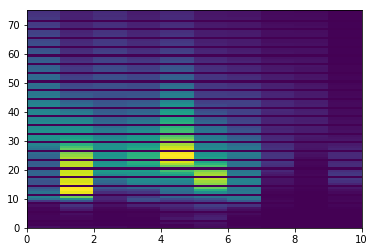

In [152]:
plt.hist2d(se['to_centre_dist'], se['segment_duration'], bins=[10,100], range=[[0,10],[0,75]]);

## Approach one, subtract the mean for each segment/hour/daytype

Try using both the mean and the median

In [ ]:
# mean_durations_by_segment_code_and_hour_and_daytype = (
#     segment_code_and_hour_and_daytype_groups["segment_duration"]
#     .mean()
#     .rename("mean_durations_by_segment_code_and_hour_and_daytype")
# )

# se = se.merge(
#     mean_durations_by_segment_code_and_hour_and_daytype.to_frame(),
#     "left",
#     left_on=["segment_code", "arrival_hour", "weekend"],
#     right_index=True,
# )

In [ ]:
# just_noise_median = se['diff_segment_and_median_by_segment_code_and_hour_and_daytype'].values

In [20]:
just_noise_mean = se['diff_segment_and_mean_by_segment_code_and_hour_and_day'].values

KeyError: 'diff_segment_and_mean_by_segment_code_and_hour_and_day'

In [19]:
just_noise_mean_percent = se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values

In [94]:
min_p, max_p = np.percentile(just_noise_median, [0.01,99.99])
just_noise_median_2_in_10000 = just_noise_median[(just_noise_median < max_p) & (just_noise_median > min_p)]

In [95]:
min_p, max_p = np.percentile(just_noise_mean, [0.01,99.99])
just_noise_mean_2_in_10000 = just_noise_mean[(just_noise_mean < max_p) & (just_noise_mean > min_p)]

In [98]:
just_noise_dwell_median = se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'].values

In [21]:
just_noise_dwell_mean = se['diff_prev_dwell_and_mean_by_segment_code_and_hour_and_daytype'].values

KeyError: 'diff_prev_dwell_and_mean_by_segment_code_and_hour_and_daytype'

In [100]:
just_noise_dwell_rules = se['diff_prev_dwell_and_dwell_predict_rules_mean'].values

In [24]:
# From: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
# And then improved...

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True, range=(-200, 200))
    x = (x + np.roll(x, -1))[:-1] / 2.0
 
    dist_continu = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]
    dist_continu = ["norminvgauss", "tukeylambda", "johnsonsu", "t", "nct", "cauchy", "laplace", "gennorm"] 

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    dist_results_name = []
    dist_results_p = []
    dist_results_D = []
    dist_results_sse = []
    dist_results_chi2_score = []
    dist_results_chi2_p = []
    params = {}

    # Estimate distribution parameters from data
    for dist_name in dist_continu:
        
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                dist = getattr(stats, dist_name)
                param = dist.fit(data)
                
                params[dist_name] = param
                D, p = stats.kstest(data, dist_name, args=param)

                # Separate parts of parameters
                arg = param[:-2]
                loc = param[-2]
                scale = param[-1]
                
                print(".", end="", flush=True)

                # Calculate fitted PDF and error with fit in distribution
                pdf = dist.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                chi2 = stats.chisquare(y, pdf)
                
                dist_results_name.append(dist_name)
                dist_results_p.append(p)
                dist_results_D.append(D)
                dist_results_sse.append(sse)
                dist_results_chi2_score.append(chi2[0])
                dist_results_chi2_p.append(chi2[1])
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = dist_name
                    best_params = param
                    best_sse = sse

        except Exception:
            pass
        
    sorted_idx = np.argsort(dist_results_sse)
    
    print("\nResults")
    for i in range(len(sorted_idx)):
        print(f"{dist_results_name[sorted_idx[i]]: <14},sse:{dist_results_sse[sorted_idx[i]]:0.6f} chi2:{dist_results_chi2_score[sorted_idx[i]]:0.6f} chi1_p:{dist_results_chi2_p[sorted_idx[i]]:0.6f} p:{dist_results_p[sorted_idx[i]]:0.4f} D:{dist_results_D[sorted_idx[i]]:0.4f}")
        

    return (best_distribution, best_params)

## Distribution fitting, journey percentage diffs, mean model

........
Results
norminvgauss  ,sse:0.000030 chi2:0.007054 chi1_p:1.000000 p:0.0000 D:0.0117
johnsonsu     ,sse:0.000050 chi2:0.010001 chi1_p:1.000000 p:0.0000 D:0.0148
t             ,sse:0.000055 chi2:0.035694 chi1_p:1.000000 p:0.0000 D:0.0470
nct           ,sse:0.000056 chi2:0.010825 chi1_p:1.000000 p:0.0000 D:0.0163
cauchy        ,sse:0.000101 chi2:0.041452 chi1_p:1.000000 p:0.0000 D:0.0732
laplace       ,sse:0.000196 chi2:0.065262 chi1_p:1.000000 p:0.0000 D:0.0793
gennorm       ,sse:0.000233 chi2:0.045624 chi1_p:1.000000 p:0.0000 D:0.0675
tukeylambda   ,sse:0.002189 chi2:0.378056 chi1_p:1.000000 p:0.0000 D:0.3276


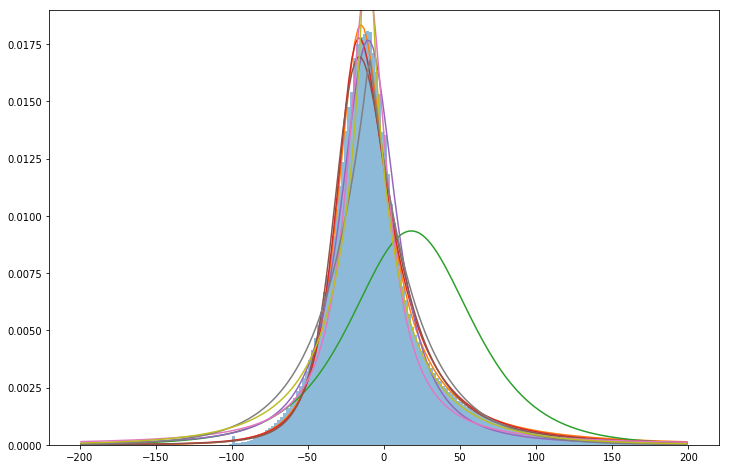

(0.383529721471459, 0.25531020060693, -17.431991635980808, 20.66105797657022)


In [25]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(just_noise_mean_percent, bins=200, density=True, alpha=0.5, range=(-200, 200))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(just_noise_mean_percent, int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

In [26]:
stats.laplace.fit(just_noise_mean_percent)

(-9.392514533228052, 29.00026243896692)

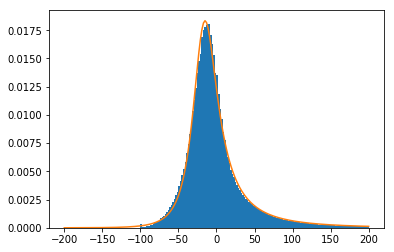

In [41]:
x = np.linspace(-200,200, 200)
plt.hist(just_noise_mean_percent, density=True, bins=200, range=(-200,200));
plt.plot(x, stats.norminvgauss.pdf(x,0.383529721471459, 0.25531020060693, -17.431991635980808, 20.66105797657022))

In [48]:
print(f"std: {np.std(just_noise_mean_percent)}")
print(f"mean: {np.mean(just_noise_mean_percent)}")

std: 57.74911932420244
mean: 0.5451191569609851


In [49]:
print(f"std: {stats.norminvgauss.std(0.383529721471459, 0.25531020060693, -17.431991635980808, 20.66105797657022)}")
print(f"mean: {stats.norminvgauss.mean(0.383529721471459, 0.25531020060693, -17.431991635980808, 20.66105797657022)}")

std: 51.75376305442416
mean: 0.9989542653517312


## Distribution fitting journey diffs, median model

.................................................................................................
Results
gennorm       ,sse:0.000698 chi2:0.074255 chi1_p:1.000000 p:0.0000 D:0.0732
tukeylambda   ,sse:0.000763 chi2:0.093113 chi1_p:1.000000 p:0.0000 D:0.0869
johnsonsu     ,sse:0.000787 chi2:0.029779 chi1_p:1.000000 p:0.0000 D:0.0442
t             ,sse:0.000912 chi2:0.101834 chi1_p:1.000000 p:0.0000 D:0.0875
cauchy        ,sse:0.000968 chi2:0.103575 chi1_p:1.000000 p:0.0000 D:0.0877
nct           ,sse:0.001290 chi2:0.054399 chi1_p:1.000000 p:0.0000 D:0.0480
norminvgauss  ,sse:0.001361 chi2:0.054237 chi1_p:1.000000 p:0.0000 D:0.0859
dweibull      ,sse:0.002928 chi2:0.139774 chi1_p:1.000000 p:0.0000 D:0.1365
dgamma        ,sse:0.005119 chi2:0.243830 chi1_p:1.000000 p:0.0000 D:0.1502
laplace       ,sse:0.008722 chi2:0.400338 chi1_p:1.000000 p:0.0000 D:0.1680
hypsecant     ,sse:0.012600 chi2:0.663808 chi1_p:1.000000 p:0.0000 D:0.1574
genlogistic   ,sse:0.014110 chi2:3.080069 chi1_p:1.000000 

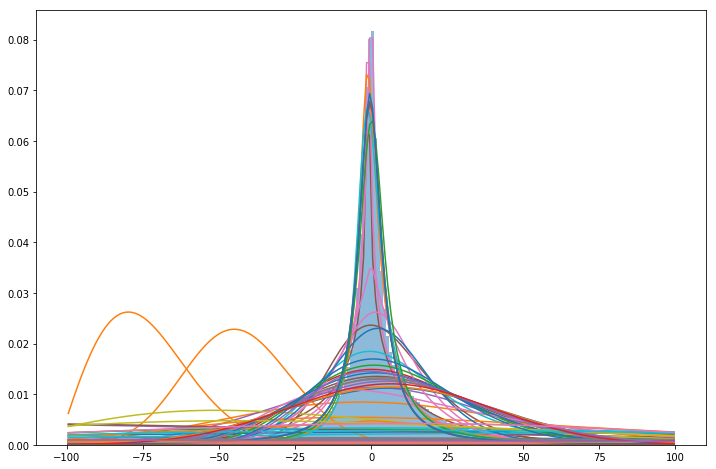

(0.5107187431289126, 5.644402672853895e-14, 1.9680290127324336)


In [97]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(just_noise_median, bins=200, density=True, alpha=0.5, range=(-100, 100))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(just_noise_median, int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

In [35]:
stats.t.fit(just_noise_mean)

(1.1802911809977377, -3.382387662589122, 6.671704789760675)

In [ ]:
best_params

## Distribution fitting journey diffs, mean model

.................................................................................................
Results
cauchy        ,sse:0.000383 chi2:0.035326 chi1_p:1.000000 p:0.0000 D:0.0282
johnsonsu     ,sse:0.000409 chi2:0.024824 chi1_p:1.000000 p:0.0000 D:0.0209
tukeylambda   ,sse:0.000489 chi2:0.036119 chi1_p:1.000000 p:0.0000 D:0.0317
t             ,sse:0.000599 chi2:0.042852 chi1_p:1.000000 p:0.0000 D:0.0336
nct           ,sse:0.000734 chi2:0.042695 chi1_p:1.000000 p:0.0000 D:0.0230
gennorm       ,sse:0.000758 chi2:0.032076 chi1_p:1.000000 p:0.0000 D:0.0227
dweibull      ,sse:0.001151 chi2:0.050965 chi1_p:1.000000 p:0.0000 D:0.0304
dgamma        ,sse:0.001746 chi2:0.089220 chi1_p:1.000000 p:0.0000 D:0.0483
laplace       ,sse:0.004077 chi2:0.211815 chi1_p:1.000000 p:0.0000 D:0.0884
norminvgauss  ,sse:0.004472 chi2:0.177832 chi1_p:1.000000 p:0.0000 D:0.1731
hypsecant     ,sse:0.006610 chi2:0.391369 chi1_p:1.000000 p:0.0000 D:0.1138
fisk          ,sse:0.007734 chi2:0.494503 chi1_p:1.000000 

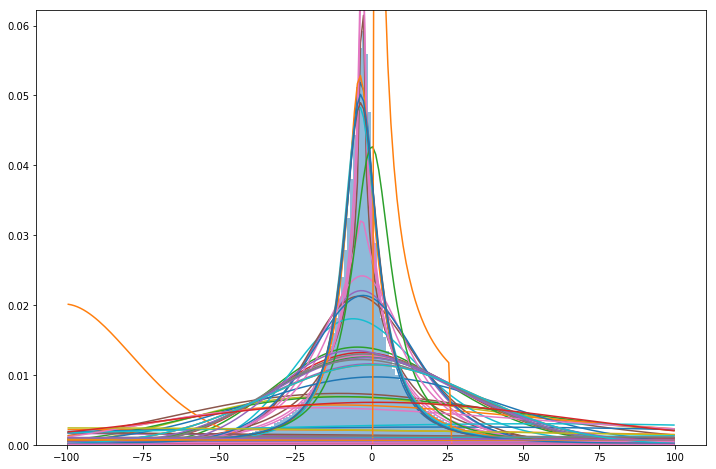

(-3.3987865683988967, 6.140268348920977)


In [101]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(just_noise_mean, bins=200, density=True, alpha=0.5, range=(-100, 100))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(just_noise_mean, int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

## Distribution fitting dwell diffs, median model

.................................................................................................
Results
gennorm       ,sse:0.001933 chi2:0.376010 chi1_p:1.000000 p:0.0000 D:0.1555
t             ,sse:0.005885 chi2:0.554366 chi1_p:1.000000 p:0.0000 D:0.1465
tukeylambda   ,sse:0.005934 chi2:0.527986 chi1_p:1.000000 p:0.0000 D:0.1463
johnsonsu     ,sse:0.006472 chi2:0.309699 chi1_p:1.000000 p:0.0000 D:0.0851
nct           ,sse:0.007800 chi2:0.409366 chi1_p:1.000000 p:0.0000 D:0.0945
cauchy        ,sse:0.012298 chi2:0.632882 chi1_p:1.000000 p:0.0000 D:0.1583
norminvgauss  ,sse:0.013806 chi2:0.474492 chi1_p:1.000000 p:0.0000 D:0.1193
dgamma        ,sse:0.015316 chi2:0.670267 chi1_p:1.000000 p:0.0000 D:0.2039
dweibull      ,sse:0.016391 chi2:0.510498 chi1_p:1.000000 p:0.0000 D:0.2039
loglaplace    ,sse:0.024860 chi2:0.859606 chi1_p:1.000000 p:0.0000 D:0.2045
laplace       ,sse:0.025803 chi2:0.936124 chi1_p:1.000000 p:0.0000 D:0.2127
hypsecant     ,sse:0.031580 chi2:1.400665 chi1_p:1.000000 

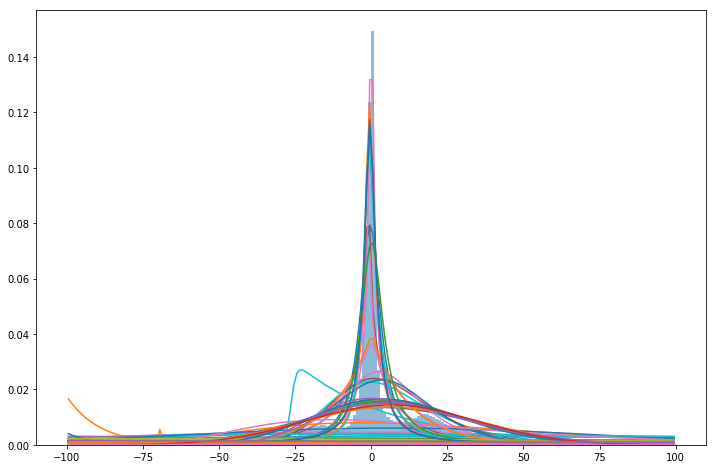

(0.23531435584758936, -6.018589028797858e-26, 0.007078991528151496)


In [102]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(just_noise_dwell_median, bins=200, density=True, alpha=0.5, range=(-100, 100))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(just_noise_dwell_median, int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

## Distribution fitting dwell diffs, mean model

.................................................................................................
Results
cauchy        ,sse:0.000673 chi2:0.094837 chi1_p:1.000000 p:0.0000 D:0.0676
johnsonsu     ,sse:0.000776 chi2:0.044201 chi1_p:1.000000 p:0.0000 D:0.0310
nct           ,sse:0.001074 chi2:0.058023 chi1_p:1.000000 p:0.0000 D:0.0386
t             ,sse:0.001168 chi2:0.095660 chi1_p:1.000000 p:0.0000 D:0.0677
gennorm       ,sse:0.001219 chi2:0.076782 chi1_p:1.000000 p:0.0000 D:0.0527
loglaplace    ,sse:0.001853 chi2:0.110392 chi1_p:1.000000 p:0.0000 D:0.0726
laplace       ,sse:0.002137 chi2:0.140448 chi1_p:1.000000 p:0.0000 D:0.0835
dweibull      ,sse:0.002853 chi2:0.100506 chi1_p:1.000000 p:0.0000 D:0.0592
dgamma        ,sse:0.003607 chi2:0.119268 chi1_p:1.000000 p:0.0000 D:0.0695
hypsecant     ,sse:0.003864 chi2:0.249130 chi1_p:1.000000 p:0.0000 D:0.0915
genlogistic   ,sse:0.004554 chi2:0.355056 chi1_p:1.000000 p:0.0000 D:0.1205
tukeylambda   ,sse:0.004636 chi2:0.202231 chi1_p:1.000000 

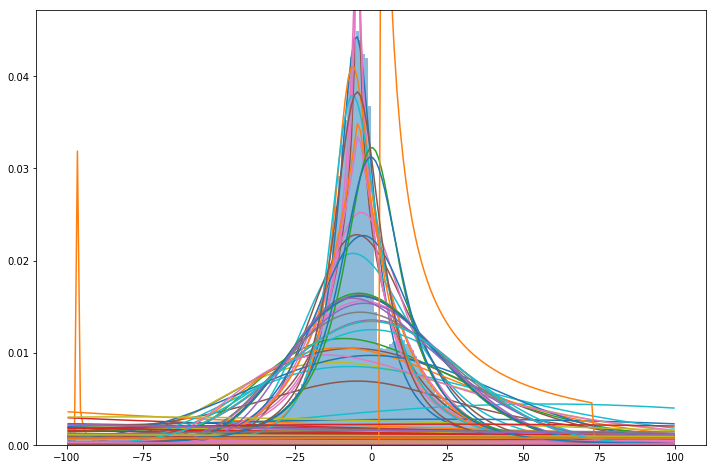

(-4.836847445347655, 7.16947946674864)


In [103]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(just_noise_dwell_mean, bins=200, density=True, alpha=0.5, range=(-100, 100))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(just_noise_dwell_mean, int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

## Distribution fitting dwell diffs, rules model

.................................................................................................
Results
cauchy        ,sse:0.000691 chi2:0.097005 chi1_p:1.000000 p:0.0000 D:0.0680
johnsonsu     ,sse:0.000778 chi2:0.043594 chi1_p:1.000000 p:0.0000 D:0.0300
nct           ,sse:0.001043 chi2:0.055197 chi1_p:1.000000 p:0.0000 D:0.0373
t             ,sse:0.001184 chi2:0.094782 chi1_p:1.000000 p:0.0000 D:0.0681
gennorm       ,sse:0.001280 chi2:0.079122 chi1_p:1.000000 p:0.0000 D:0.0548
laplace       ,sse:0.002069 chi2:0.137055 chi1_p:1.000000 p:0.0000 D:0.0850
dweibull      ,sse:0.002851 chi2:0.100902 chi1_p:1.000000 p:0.0000 D:0.0631
dgamma        ,sse:0.002861 chi2:0.111349 chi1_p:1.000000 p:0.0000 D:0.0731
hypsecant     ,sse:0.003786 chi2:0.243521 chi1_p:1.000000 p:0.0000 D:0.0892
genlogistic   ,sse:0.004427 chi2:0.503520 chi1_p:1.000000 p:0.0000 D:0.1184
logistic      ,sse:0.004732 chi2:0.342192 chi1_p:1.000000 p:0.0000 D:0.1123
exponnorm     ,sse:0.005001 chi2:262.180204 chi1_p:0.00177

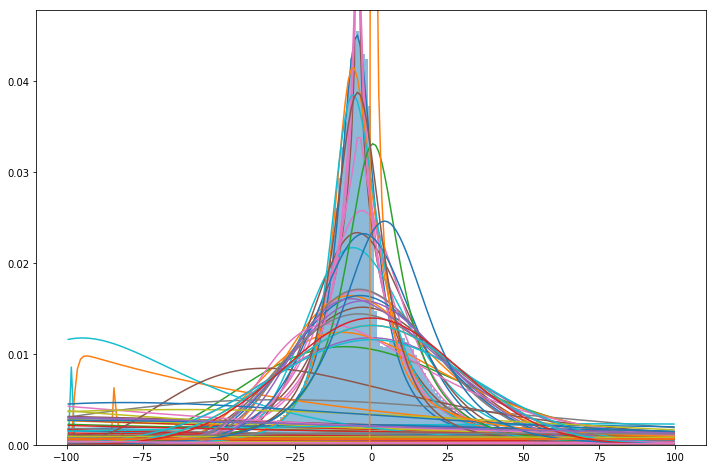

(-4.704834737568162, 7.060088048429708)


In [104]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.hist(just_noise_dwell_rules, bins=200, density=True, alpha=0.5, range=(-100, 100))
# Save plot limits
dataYLim = ax.get_ylim()

one_percent_data = np.random.choice(just_noise_dwell_rules, int(se.shape[0]/100), replace=False)

st = stats
best_dist, best_params = best_fit_distribution(one_percent_data, 200, ax)

ax.set_ylim(dataYLim);

plt.show()

print(best_params)

## Using a method two on journey times

In [ ]:
stats.probplot(just_noise, sparams=(-0.3848045122209864, 4.753788866524921), dist="cauchy", plot=plt)

In [ ]:
stats.cauchy.fit(differences)

In [ ]:
rv = stats.cauchy(loc=0, scale=7.488655070821551/2)

In [ ]:
min_p, max_p = np.percentile(just_noise, [0.1,99.9])

x = np.linspace(-100,100, 200)
plt.plot(x, np.clip(rv.pdf(x), min_p, max_p))

## Analytic Noise Standard Deviation using distribution found from differences

In [ ]:
min_p, max_p = np.percentile(just_noise_median, [0.1,99.9])

samples = stats.cauchy.rvs(loc=0, scale=7.488655070821551/2, size=100000000)

# Deciding how/where to filter is quite a hack! 

print("######### HACK ##############")
samples_truncated = samples[(samples > min_p) & (samples < max_p)]
print("####### END HACK ############")

np.std(samples_truncated)

In [ ]:
len(samples_truncated)/len(samples)

In [ ]:
fig, ax1 = plt.subplots()

granularity = 300

ax1.hist(just_noise, bins=granularity, range=(-150, 150));

# ax2 = ax1.twinx()
x = np.linspace(-150, 150, granularity)
ax1.plot(x, stats.cauchy.pdf(x, -0.3848045122209864, 4.753788866524921) * len(just_noise), label="just noise")
ax1.plot(x, stats.cauchy.pdf(x, 0, 7.488655070821551/2) * len(just_noise), label="diffs")
ax1.legend()

## Analytic Noise Standard Deviation using Just Noise

In [ ]:
np.std(just_noise)

In [ ]:
np.std(just_noise_2_in_10000)

### Memory stuff

In [ ]:
se.memory_usage().sort_values()

In [ ]:
def exclude_columns_containing(se, to_remove):

    min_cols = [c for c in se.columns if not any(x in c for x in to_remove)]

    se_min = se[min_cols]

    return se_min


In [ ]:
se = exclude_columns_containing(se, ["prev_segment_code_",
            "next_segment_code_",
            "prev_event_index_",
            "next_event_index_",
            "offset_timestamp_5_"])

se = exclude_columns_containing(se, ["prev_stop_", "next_stop_", "road"])

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [ ]:
13149250104 - 4854970495